Improting the libraries and the dataset
[]: # Path: LSTM.ipynb

In [150]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta ## Technical Analysis Indicators
import yfinance as yf
from pytrends.request import TrendReq

data = yf.download(tickers = 'BTC-USD', start = '2015-01-01',end = '2023-01-01')
data.to_csv('data/currencies/bitcoin/btc_dates_daily.csv')
data.head(10)
data.shape



[*********************100%%**********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(


(2922, 6)

Since Google doesn't provide an official API for Google Trends, and using the unofficial API pytrends doesn't provide data daily (only monthly), we will use the data from the website itself. We will use the data from every month to fill the gaps between the months. For each daily volume, we will take the product with the monthly volume to obtain a graph and then we will scale it to obtain the daily data in 6 years between 2015 and 2021.


In [151]:
import pandas as pd

column_names_monthly = ['Month', 'monthVol']
column_names_daily = ['Day', 'dayVol']

dfM = pd.read_csv('data/currencies/bitcoin/gTrends/monthly/multiTimeline-6.csv', names=column_names_monthly)

# Define an initially empty DataFrame to accumulate results
combined_df = pd.DataFrame(columns=column_names_daily)

# Define the range for iteration (4 to 78)
for i in range(0, 96):
    dfD = pd.read_csv('data/currencies/bitcoin/gTrends/Months/multiTimeline-{}.csv'.format(i+6), names=column_names_daily, skiprows=2)
    monthlyVolume = pd.to_numeric(dfM.at[i+2, 'monthVol'], errors='coerce')
    dfD_copy = dfD.copy()
    dfD_copy['dayVol'] = pd.to_numeric(dfD_copy['dayVol'], errors='coerce')
    dfD_copy['dayVol'] *= monthlyVolume
    combined_df = pd.concat([combined_df, dfD_copy], ignore_index=True)    
# Save the combined DataFrame to a CSV file
combined_df.to_csv('data/currencies/bitcoin/gTrends/combined_data.csv', index=False)


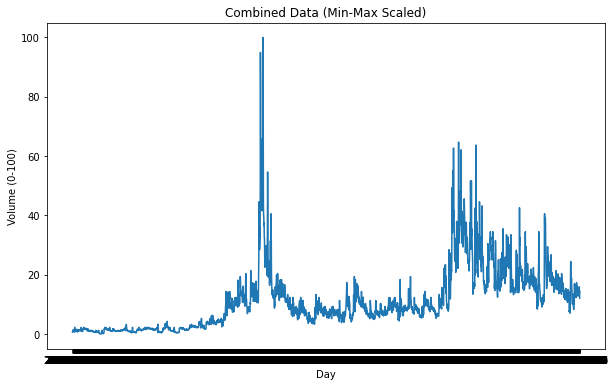

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

column_names = ['Day', 'volume']
column_names2 = ['Month', 'volume']

dfM = pd.read_csv('data/currencies/bitcoin/gTrends//combined_data.csv', names=column_names)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the 'volume' column
dfM['volume'] = scaler.fit_transform(dfM[['volume']])

# Plot the min-max scaled 'volume' values in the DataFrame
plt.figure(figsize=(10, 6))
plt.plot(dfM['Day'], dfM['volume'])
plt.title('Combined Data (Min-Max Scaled)')
plt.xlabel('Day')
plt.ylabel('Volume (0-100)')
plt.show()




In [172]:
print(dfM.shape)
print(data.shape)

(2922, 2)
(2772, 12)


In [173]:
gTrends = dfM['volume'].tolist()


We add the economic indicators to obtain a prediction of the bitcoin market price without using the google trends volume we obtained first. After finding a prediction with the market values themselves, we will add the google trends volume to see if the prediction improves.



In [174]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15) ## Relative Strength Index
data['EMAF']=ta.ema(data.Close, length=20) ## Exponential Moving Average Fast
data['EMAM']=ta.ema(data.Close, length=100) ## Exponential Moving Average Medium
data['EMAS']=ta.ema(data.Close, length=150) ## Exponential Moving Average Slow

data['gTrends'] = gTrends ## Google Trends


data['Target'] = data['Adj Close']-data.Open ## Target is the difference between the opening price and the future closing price
data['Target'] = data['Target'].shift(-1) ## Shift the target by one day


data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))] ## TargetClass is 1 if the price goes up and 0 if it goes down
data['TargetNextClose'] = data['Adj Close'].shift(-1) ## TargetNextClose is the future closing price



data.reset_index(inplace = True) ## Reset the index
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'Close'

In [ ]:
data.dropna(inplace=True) ## Drop the NaN values

In [175]:
data_set = data.iloc[:, 0:12]#.values
pd.set_option('display.max_columns', None)

data_set.head(-20)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,gTrends,Target,TargetClass,TargetNextClose
149,237.091995,237.093002,232.046005,233.345001,44.997251,236.674144,240.674675,245.268894,1.229591,-2.944992,0,230.190002
150,233.134995,233.251999,229.542007,230.190002,41.186285,236.056607,240.467058,245.069174,0.927232,-7.307007,0,222.925995
151,230.233002,231.712997,221.296005,222.925995,34.068533,234.806073,240.119710,244.775886,0.221729,2.908997,1,225.802994
152,222.893997,226.416000,222.419006,225.802994,38.573317,233.948637,239.836210,244.524590,0.181415,0.138000,1,225.873993
153,225.735992,227.404007,223.929993,225.873993,38.684089,233.179623,239.559731,244.277562,0.161258,-1.447998,0,224.324005
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,16975.238281,17091.863281,16939.921875,17089.503906,48.333065,16985.643049,19184.410767,20914.011268,15.541222,-241.378906,0,16848.126953
2897,17089.505859,17109.376953,16750.558594,16848.126953,45.608948,16972.546278,19138.147721,20860.158495,15.904052,386.125000,1,17233.474609
2898,16847.349609,17267.916016,16788.783203,17233.474609,50.391480,16997.396595,19100.431422,20812.122947,16.629712,-98.996094,0,17133.152344
2899,17232.148438,17280.546875,17100.835938,17133.152344,49.185133,17010.325714,19061.475401,20763.394860,13.727071,-5.496094,0,17128.724609


After building the data set, we will split it into training and test set. We will use the first 5 years for training and the last year for testing.



In [158]:
from sklearn.preprocessing import MinMaxScaler ## Scale the data
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae


sc = MinMaxScaler(feature_range=(0,1)) ## Scale the data between 0 and 1
data_set_scaled = sc.fit_transform(data_set) ## Fit and transform the data
print(data_set_scaled) ## Print the scaled data

[[4.01308820e-04 1.65889151e-04 4.90749157e-04 ... 5.08352680e-01
  0.00000000e+00 2.92400230e-04]
 [3.42547010e-04 1.09868372e-04 4.52914413e-04 ... 5.08059408e-01
  0.00000000e+00 1.84555767e-04]
 [2.99452160e-04 8.74221386e-05 3.28319501e-04 ... 5.08746262e-01
  1.00000000e+00 2.27268884e-04]
 ...
 [2.45120496e-01 2.41270544e-01 2.46258312e-01 ... 5.14602970e-01
  1.00000000e+00 2.43953999e-01]
 [2.42683921e-01 2.39572653e-01 2.46426438e-01 ... 5.05945793e-01
  0.00000000e+00 2.43363767e-01]
 [2.44005695e-01 2.39451188e-01 2.44912306e-01 ... 5.04773679e-01
  0.00000000e+00 2.42545880e-01]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type`

We set the backcandles as the past 30 days to predict the next day. We will use the MinMaxScaler to scale the data between 0 and 1. We will use the LSTM model to predict the next day. We will use the Adam optimizer and the mean squared error as the loss function. We will use the early stopping to stop the training when the loss function doesn't improve after 10 epochs. We will use the model checkpoint to save the best model. We will use the model to predict the test set and we will inverse the scaling to obtain the real values. We will plot the real values and the predicted values to see the accuracy of the model. We will calculate the root mean squared error to see the accuracy of the model.

In [132]:
# multiple feature from data provided to the model
X = []

backcandles = 30 ## Number of previous candles(days) to consider
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2]) 

#Erase first elements of y because of backcandles to match X length
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2772
[[[4.01308820e-04 1.65889151e-04 4.90749157e-04 ... 1.07937379e-04
   6.10138607e-05 6.22657436e-05]
  [3.42547010e-04 1.09868372e-04 4.52914413e-04 ... 9.81318403e-05
   5.72208927e-05 5.84311288e-05]
  [2.99452160e-04 8.74221386e-05 3.28319501e-04 ... 7.82752844e-05
   5.08751828e-05 5.28000411e-05]
  ...
  [4.83162636e-04 2.62966331e-04 6.34397239e-04 ... 1.64598100e-04
   2.91056871e-05 8.97877279e-06]
  [4.97195852e-04 3.73666144e-04 6.58029026e-04 ... 1.80850770e-04
   3.34692385e-05 1.11394591e-05]
  [6.07175694e-04 3.71230352e-04 7.23257774e-04 ... 1.92562850e-04
   3.70304524e-05 1.27682595e-05]]

 [[3.42547010e-04 1.09868372e-04 4.52914413e-04 ... 9.81318403e-05
   5.72208927e-05 5.84311288e-05]
  [2.99452160e-04 8.74221386e-05 3.28319501e-04 ... 7.82752844e-05
   5.08751828e-05 5.28000411e-05]
  [1.90467294e-04 1.01657894e-05 3.45287751e-04 ... 6.46605241e-05
   4.56959226e-05 4.79751682e-05]
  ...
  [4.97195852e-04 3.73666144e-04 6.58029026e-04 ... 1.80850770e-04
   3.

In [133]:
# split data into train test sets
splitlimit = int(len(X)*0.8) ## Split the data into 80% training and 20% testing
print(splitlimit) ## Print the split limit to check
X_train, X_test = X[:splitlimit], X[splitlimit:] ## Split the data into training and testing
y_train, y_test = y[:splitlimit], y[splitlimit:] ## Split the data into training and testing
print(X_train.shape) ## Print the shape of the training data
print(X_test.shape) ## Print the shape of the testing data
print(y_train.shape) ## Print the shape of the training data
print(y_test.shape) ## Print the shape of the testing data
print(y_train) ## Print the training data

2193
(2193, 30, 8)
(549, 30, 8)
(2193, 1)
(549, 1)
[[0.00078058]
 [0.0007145 ]
 [0.00066686]
 ...
 [0.50810131]
 [0.52938277]
 [0.51710566]]


In [122]:
from keras.layers import LSTM
from keras.layers import Dense

import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Activation
import numpy as np
tf.random.set_seed(20)

from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

In [123]:
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
# Add the first LSTM layer
lstm1 = LSTM(400, return_sequences=True, name='first_layer')(lstm_input)
# Add a second LSTM layer
lstm2 = LSTM(800, name='third_layer')(lstm1)

# Add a Dense layer
dense_layer = Dense(1, name='dense_layer')(lstm2)

# Create the model
model1 = Model(inputs=lstm_input, outputs=dense_layer)
adam = optimizers.Adam()

model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 30, 8)]           0         
                                                                 
 first_layer (LSTM)          (None, 30, 400)           654400    
                                                                 
 third_layer (LSTM)          (None, 800)               3843200   
                                                                 
 dense_layer (Dense)         (None, 1)                 801       
                                                                 
Total params: 4498401 (17.16 MB)
Trainable params: 4498401 (17.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=adam, metrics=[RootMeanSquaredError()])


In [125]:
model1.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=15, epochs=5, callbacks=[cp1])

Epoch 1/5
147/147 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0694INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


147/147 [==============================] - 44s 288ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 2/5
147/147 [==============================] - 38s 261ms/step - loss: 7.4823e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 3/5
147/147 [==============================] - ETA: 0s - loss: 6.1412e-04 - root_mean_squared_error: 0.0248INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


147/147 [==============================] - 41s 282ms/step - loss: 6.1412e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 4/5
147/147 [==============================] - ETA: 0s - loss: 3.6528e-04 - root_mean_squared_error: 0.0191INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


147/147 [==============================] - 42s 287ms/step - loss: 3.6528e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 5/5
147/147 [==============================] - ETA: 0s - loss: 4.0060e-04 - root_mean_squared_error: 0.0200INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


147/147 [==============================] - 42s 288ms/step - loss: 4.0060e-04 - root_mean_squared_error: 0.0200 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322


In [134]:
from keras.models import load_model
model1 = load_model('model1/')

In [135]:
y_pred = model1.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

18/18 [==============================] - 2s 103ms/step
[0.49816158] [0.49530045]
[0.50560015] [0.50012449]
[0.501369] [0.5115785]
[0.49424806] [0.52077191]
[0.49311563] [0.49788205]
[0.49825147] [0.50514478]
[0.49651462] [0.49950512]
[0.49439076] [0.48498596]
[0.49268183] [0.49865417]
[0.48491988] [0.49453441]


this graph is the first prediction of the model without using the google trends volume. We can see that the model is not very accurate. The RMSE is 0.024. We will add the google trends volume to see if the prediction improves.

Mean Absolute Error: 0.027598755
mean_squared_error: 0.0015026152


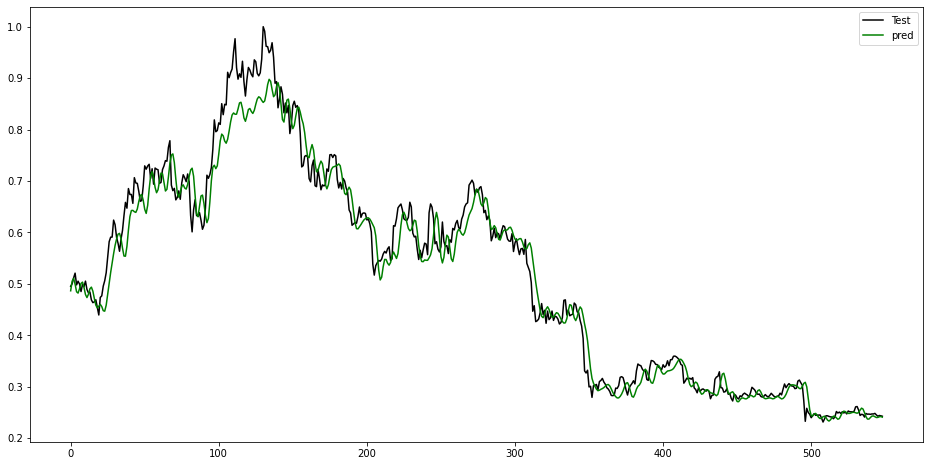

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Your code to create 'y_test' and 'y_pred'...

plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Test')
plt.plot(y_pred, color='green', label='pred')
plt.legend()

# Calculate the errors
mean_absolute_error = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy())
mean_squared_error = np.mean(tf.keras.metrics.mean_squared_error(y_test, y_pred).numpy())

print("Mean Absolute Error:", mean_absolute_error)
print("mean_squared_error:", mean_squared_error)
plt.show()


In [159]:
pdPredictions = pd.DataFrame(y_pred)
pdPredictions.to_csv('data/currencies/bitcoin/Results/Data/btc_predictions_NOGT.csv')

ValueError: non-broadcastable output operand with shape (549,1) doesn't match the broadcast shape (549,12)

Now we add the google trends volume hence the input is now 9 features. We will use the same model as before to compare the results. We will use the same parameters as before. We will use the model to predict the test set and we will inverse the scaling to obtain the real values. We will plot the real values and the predicted values to see the accuracy of the model. We will calculate the root mean squared error to see the accuracy of the model.

In [160]:
# multiple feature from data provided to the model
X = []

print(data_set_scaled.shape[0])
for j in range(9):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2]) 

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2772
[[[4.01308820e-04 1.65889151e-04 4.90749157e-04 ... 6.10138607e-05
   6.22657436e-05 1.22959081e-02]
  [3.42547010e-04 1.09868372e-04 4.52914413e-04 ... 5.72208927e-05
   5.84311288e-05 9.27232413e-03]
  [2.99452160e-04 8.74221386e-05 3.28319501e-04 ... 5.08751828e-05
   5.28000411e-05 2.21729490e-03]
  ...
  [4.83162636e-04 2.62966331e-04 6.34397239e-04 ... 2.91056871e-05
   8.97877279e-06 1.20943358e-03]
  [4.97195852e-04 3.73666144e-04 6.58029026e-04 ... 3.34692385e-05
   1.11394591e-05 1.81415037e-03]
  [6.07175694e-04 3.71230352e-04 7.23257774e-04 ... 3.70304524e-05
   1.27682595e-05 2.01572264e-03]]

 [[3.42547010e-04 1.09868372e-04 4.52914413e-04 ... 5.72208927e-05
   5.84311288e-05 9.27232413e-03]
  [2.99452160e-04 8.74221386e-05 3.28319501e-04 ... 5.08751828e-05
   5.28000411e-05 2.21729490e-03]
  [1.90467294e-04 1.01657894e-05 3.45287751e-04 ... 4.56959226e-05
   4.79751682e-05 1.81415037e-03]
  ...
  [4.97195852e-04 3.73666144e-04 6.58029026e-04 ... 3.34692385e-05
   1.

In [161]:
# split data into train test sets
splitlimit = int(len(X)*0.8) ## Split the data into 80% training and 20% testing
print(splitlimit) ## Print the split limit to check
X_train, X_test = X[:splitlimit], X[splitlimit:] ## Split the data into training and testing
y_train, y_test = y[:splitlimit], y[splitlimit:] ## Split the data into training and testing
print(X_train.shape) ## Print the shape of the training data
print(X_test.shape) ## Print the shape of the testing data
print(y_train.shape) ## Print the shape of the training data
print(y_test.shape) ## Print the shape of the testing data
print(y_train) ## Print the training data

2193
(2193, 30, 9)
(549, 30, 9)
(2193, 1)
(549, 1)
[[0.00078058]
 [0.0007145 ]
 [0.00066686]
 ...
 [0.50810131]
 [0.52938277]
 [0.51710566]]


In [162]:
lstm_input = Input(shape=(backcandles, 9), name='lstm_input')
# Add the first LSTM layer
lstm1 = LSTM(400, return_sequences=True, name='first_layer')(lstm_input)
# Add a second LSTM layer
lstm2 = LSTM(800, name='third_layer')(lstm1)

# Add a Dense layer
dense_layer = Dense(1, name='dense_layer')(lstm2)
# Add a final activation layer
output = Activation('sigmoid', name='output')(dense_layer)

# Create the model
model1_GT = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model1_GT.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 30, 9)]           0         
                                                                 
 first_layer (LSTM)          (None, 30, 400)           656000    
                                                                 
 third_layer (LSTM)          (None, 800)               3843200   
                                                                 
 dense_layer (Dense)         (None, 1)                 801       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 4500001 (17.17 MB)
Trainable params: 4500001 (17.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [163]:
cp1_GT = ModelCheckpoint('model1GT/', save_best_only=True)
model1_GT.compile(loss=MeanSquaredError(), optimizer=adam, metrics=[RootMeanSquaredError()])


In [165]:
model1_GT.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=15, epochs=5, callbacks=[cp1_GT])

Epoch 1/5
147/147 [==============================] - 38s 261ms/step - loss: 4.6914e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 2/5
147/147 [==============================] - 41s 281ms/step - loss: 4.1685e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 3/5
147/147 [==============================] - ETA: 0s - loss: 4.9708e-04 - root_mean_squared_error: 0.0223INFO:tensorflow:Assets written to: model1GT/assets


INFO:tensorflow:Assets written to: model1GT/assets


147/147 [==============================] - 45s 305ms/step - loss: 4.9708e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 4/5
147/147 [==============================] - 39s 262ms/step - loss: 3.6652e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 5/5
147/147 [==============================] - 39s 264ms/step - loss: 3.4973e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395


In [166]:
model1_GT = load_model('model1GT/')

In [167]:
y_pred = model1_GT.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

18/18 [==============================] - 3s 118ms/step
[0.48645613] [0.49530045]
[0.50513744] [0.50012449]
[0.510673] [0.5115785]
[0.49934855] [0.52077191]
[0.48449105] [0.49788205]
[0.4819843] [0.50514478]
[0.4906028] [0.49950512]
[0.5007395] [0.48498596]
[0.50328434] [0.49865417]
[0.4932393] [0.49453441]


This graph is the second prediction of the model using the google trends volume. We can see that the model is more accurate than the first one(RSME 0.0277 -> 0.0219). Even the accuracy has improved by  we can not draw the conclusion that there is a significant improvement. However, the initial idea is still valid. Now we can add the reddit sentiment analysis to see if the prediction improves.

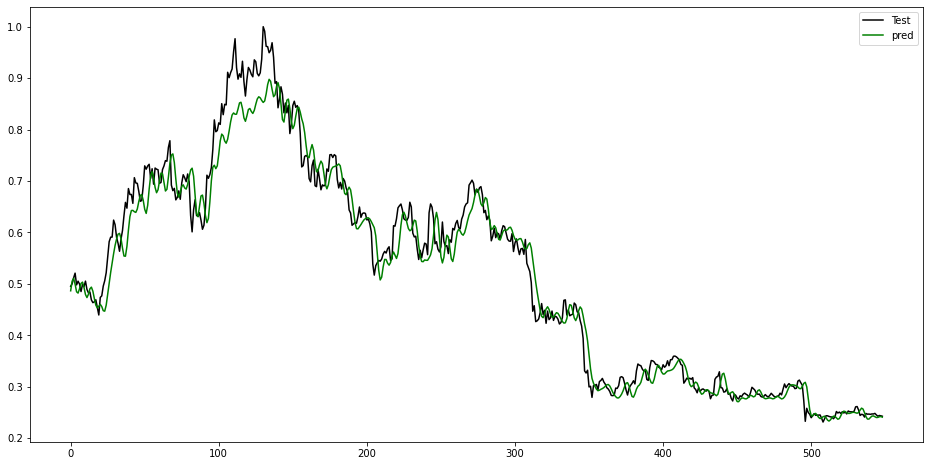

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Your code to create 'y_test' and 'y_pred'...

plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Test')
plt.plot(y_pred, color='green', label='pred')
plt.legend()

# Calculate the errors
mean_absolute_error = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy())
mean_squared_error = np.mean(tf.keras.metrics.mean_squared_error(y_test, y_pred).numpy())

plt.show()


This graph is still the second prediction of the model using the google trends volume. It is to observe the prediction compared the test and train data set too. 

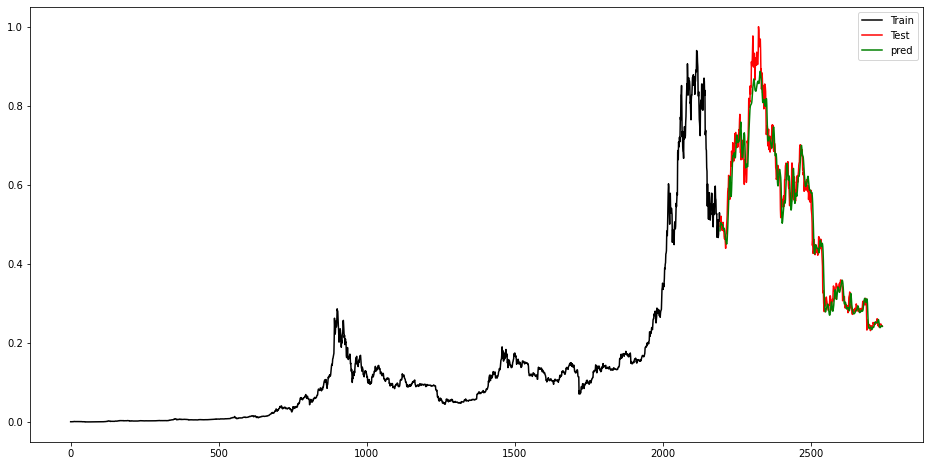

In [ ]:
import matplotlib.pyplot as plt

start_point = len(y_train)  # Start of 'pred' segment

plt.figure(figsize=(16, 8))

# Plot the 'Train' segment in red
plt.plot(y_train, color='black', label='Train')

# Plot the 'Test' segment in black
plt.plot(range(start_point, start_point + len(y_pred)), y_test, color='red', label='Test')

# Plot the 'pred' segment starting from 'start_point' in green
plt.plot(range(start_point, start_point + len(y_pred)), y_pred, color='green', label='pred')

plt.legend()
plt.savefig('data/bitcoin/Results/Graphs/2LSTM_af_GT_TTP.png', bbox_inches='tight')
plt.show()
